In [1]:
using Plots
using Dates
using DelimitedFiles
# import Pkg
# Pkg.add("CSV")
# import CSV
# using Queryverse

In [2]:
mutable struct Grid
    xmin::Float64
    xmax::Float64
    nx::Int64
    n_ghost::Int64
    tot_nx::Int64
    dx::Float64 
    x::Vector{Float64}
    
    function Grid(xmin, xmax, nx)
        new(xmin, xmax, nx, 1, 0, 0.0, zeros(nx))
    end
end

function tot_nx(grid::Grid)
    grid.tot_nx=grid.nx+2*grid.n_ghost    
end

function get_dx(grid::Grid)
    grid.dx=(grid.xmax-grid.xmin)/(grid.nx-1)    
end

function get_grid(grid::Grid)
    resize!(grid.x, grid.tot_nx)
    for i=2:grid.tot_nx-1
        grid.x[i]=(i-2)*grid.dx
    end
    grid.x[1]=grid.x[2]
    grid.x[end]=grid.x[end-1]
end

get_grid (generic function with 1 method)

In [3]:
function prim_to_cons_vars(pv::Matrix{Float64})
    cv=zeros(Float64, size(pv))
    cv[:, 1] = pv[:, 1]
    cv[:, 2] = pv[:, 1] .* pv[:, 2]
    cv[:, 3] = pv[:, 1] .* (pv[:, 3] ./ (pv[:, 1] * (1.4 - 1.0)) + 0.5 * pv[:, 2] .^ 2)
    return cv
end

prim_to_cons_vars (generic function with 1 method)

In [4]:
function cons_to_prim_vars(cv::Matrix{Float64})
    pv = zeros(Float64, size(cv))
    pv[:, 1] = cv[:, 1]
    pv[:, 2] = cv[:, 2] ./ cv[:, 1]
    pv[:, 3] = (cv[:, 3] ./ cv[:, 1] - 0.5 * pv[:, 2] .^ 2) .* cv[:, 1] * (1.4 - 1.0)
    return pv
end

cons_to_prim_vars (generic function with 1 method)

In [5]:
function conv_vars_to_flux(cv::Matrix{Float64})
    pv = cons_to_prim_vars(cv)
    f = zeros(Float64, size(cv))
    f[:, 1] = cv[:, 2]
    f[:, 2] = pv[:, 3] + cv[:, 2] .* pv[:, 2]
    f[:, 3] = pv[:, 3] .* pv[:, 2] + cv[:, 3] .* pv[:, 2]
    return f
end

conv_vars_to_flux (generic function with 1 method)

In [6]:
function time_step(cv:: Matrix{Float64}, dx::Float64, cfl::Float64 = 0.2)
    pv = cons_to_prim_vars(cv)
    a = sqrt.(1.4 * pv[:, 3] ./ pv[:, 1])
    eig_val = abs.(pv[:, 2] + a)
    dt = cfl * dx ./ eig_val
    
    return minimum(dt)
end

time_step (generic function with 2 methods)

In [7]:
function llf_flux(cv:: Matrix{Float64})
    f = conv_vars_to_flux(cv)
    pv = cons_to_prim_vars(cv)
    a = sqrt.(1.4 * pv[:, 3] ./ pv[:, 1])
    
    eig_val_l = abs.(pv[2:end-1, 2]) + a[2:end-1]
    eig_val_r = abs.(pv[3:end, 2]) + a[3:end]
    max_eig_val = max.(eig_val_l, eig_val_r)
    f_iph = 0.5 * (f[2:end-1, :] + f[3:end, :]) - 0.5 * max_eig_val .* (cv[3:end, :] - cv[2:end-1, :])
    
    eig_val_l = abs.(pv[1:end-2, 2]) + a[1:end-2]
    eig_val_r = abs.(pv[2:end-1, 2]) + a[2:end-1]
    max_eig_val = max.(eig_val_l, eig_val_r)
    f_imh = 0.5 * (f[2:end-1, :] + f[1:end-2, :]) - 0.5 * max_eig_val .* (cv[2:end-1, :] - cv[1:end-2, :])

    return f_iph - f_imh
end

llf_flux (generic function with 1 method)

In [8]:
function initialize(grid::Vector{Float64}, xloc::Float64, prim_var_l::Vector{Float64}, 
    prim_var_r::Vector{Float64}, prim_vars::Matrix{Float64})
    for i=1:size(prim_vars)[1]
        if (grid[i]<xloc)
            prim_vars[i,:] = prim_var_l
        else
            prim_vars[i,:] = prim_var_r
        end
    end    
end


initialize (generic function with 1 method)

In [9]:
function boundary_conditions!(cv::Matrix{Float64})
    pv = cons_to_prim_vars(cv)
    pv[1, :] = pv[2, :]
    pv[end, :] = pv[end-1, :]
    cv = prim_to_cons_vars(pv)
end

boundary_conditions! (generic function with 1 method)

**Simulation parameters**

In [10]:
grid = Grid(0, 1, 10001)
tot_nx(grid)
get_dx(grid)
get_grid(grid)

prim_var_l = Vector{Float64}(undef, 3)
prim_var_r = Vector{Float64}(undef, 3)
prim_var_l = [1.0, 0.75, 1.0]
prim_var_r = [0.125, 0.0, 0.1]
prim_vars = Matrix{Float64}(undef, grid.tot_nx, 3)
cons_vars = Matrix{Float64}(undef, grid.tot_nx, 3)
flux = Matrix{Float64}(undef, grid.tot_nx, 3)
cfl_num=0.9

initialize(grid.x, 0.3, prim_var_l, prim_var_r,  prim_vars)
cons_vars = prim_to_cons_vars(prim_vars)
flux = conv_vars_to_flux(cons_vars)

10003×3 Array{Float64,2}:
 0.75  1.5625  2.83594
 0.75  1.5625  2.83594
 0.75  1.5625  2.83594
 0.75  1.5625  2.83594
 0.75  1.5625  2.83594
 0.75  1.5625  2.83594
 0.75  1.5625  2.83594
 0.75  1.5625  2.83594
 0.75  1.5625  2.83594
 0.75  1.5625  2.83594
 0.75  1.5625  2.83594
 0.75  1.5625  2.83594
 0.75  1.5625  2.83594
 ⋮             
 0.0   0.1     0.0
 0.0   0.1     0.0
 0.0   0.1     0.0
 0.0   0.1     0.0
 0.0   0.1     0.0
 0.0   0.1     0.0
 0.0   0.1     0.0
 0.0   0.1     0.0
 0.0   0.1     0.0
 0.0   0.1     0.0
 0.0   0.1     0.0
 0.0   0.1     0.0

**Simulation**

In [11]:
start_time = now()
time = 0
cv_new=zeros(Float64, size(cons_vars))
while time <= 0.2
    t_dt = time_step(cons_vars, grid.dx, cfl_num)
    flux = llf_flux(cons_vars)
    cv_new[2:end-1, :] = cons_vars[2:end-1, :] - (t_dt / grid.dx) * flux
    global cons_vars = boundary_conditions!(cv_new)
    global time += t_dt
    # print(time, "\n")
end
end_time = now()
println("Total time taken for the simulation is: ", canonicalize(end_time-start_time))

Total time taken for the simulation is: 10 seconds, 474 milliseconds


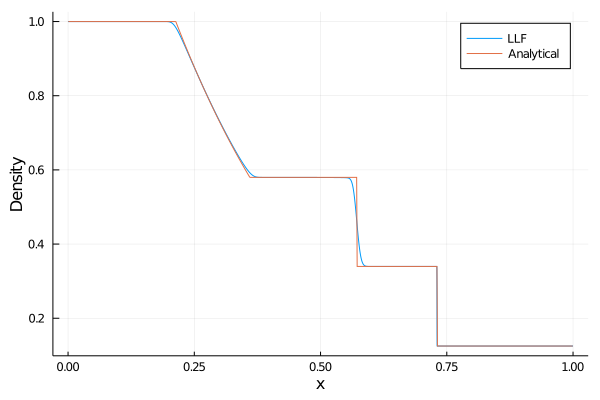

In [12]:
analytical = readdlm("./data/shock_tube.dat", ',', Float64)
plot!(grid.x, cons_vars[:,1], label="LLF")
plot!(analytical[:,1], analytical[:,2], label="Analytical")
xlabel!("x")
ylabel!("Density")